<a href="https://colab.research.google.com/github/RAVIAPTISWETHA/-Deep-Learning-Applications-in-Heart-Diseases-Using-ECG-Images/blob/main/Version1_DLA_Heart_Diseases_using_ECG_Images_OD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from tensorflow.keras import layers, models, optimizers, Input
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from tensorflow.keras.applications import VGG16
!pip install keras-tuner
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.models import Model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.5 MB/s eta 0:00:00


/tmp/ipython-input-2524332242.py:15: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Loading

In [3]:
dir_mendeley = '/content/drive/My Drive/Colab Notebooks/ECGM'

In [4]:
def load_dataset(dir ):
    folders = os.listdir(dir)
    file_path = []
    labels = []
    sub_folders =[]
    for folder in folders:
        sub_folder = os.path.join(dir, folder)
        sub_list = os.listdir(sub_folder)
        for file in sub_list:
            f_path = os.path.join(sub_folder, file)
            file_path.append(f_path)
            labels.append(folder)
    return file_path, labels
train_file_path, train_labels = load_dataset(dir_mendeley)
print(len(train_file_path))
mendeley_path, mendeley_labels = load_dataset(dir_mendeley )
df = pd.DataFrame({'file_path': mendeley_path, "labels": mendeley_labels})
df.labels.value_counts()

707


,count
labels,
Normal Person,295
Abnormal heartbeat,241
History of MI,171


## Class Distribution

/tmp/ipython-input-3745455416.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='labels', order=df['labels'].value_counts().index, palette=['grey', 'lightblue', 'yellow'])


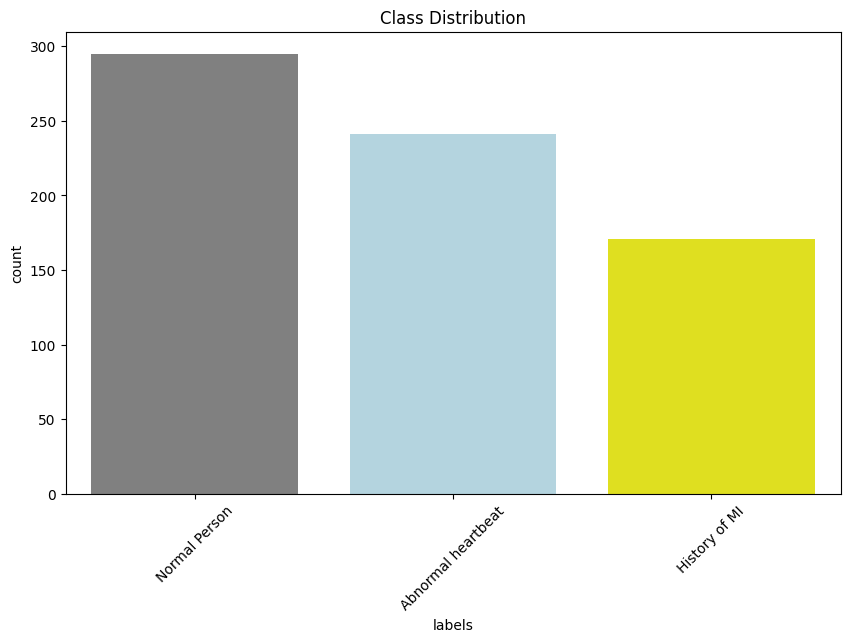

In [5]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='labels', order=df['labels'].value_counts().index, palette=['grey', 'lightblue', 'yellow'])
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

## Data Preprocessing

In [6]:
def prepare_image(image_path, target_size=(224,224)):
    try:
        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: could not read the image at {image_path}")
            return None
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        height, width = image.shape[:2]
        aspect_ratio = width / height
        target_width = target_size[0]
        target_height = target_size[1]

        if width > height:
            new_width = target_width
            new_height = int(new_width / aspect_ratio)
        else:
            new_height = target_height
            new_width = int(new_height * aspect_ratio)
        if new_width <= 0 or new_height <= 0:
             print(f"Warning: Calculated new dimensions are invalid for {image_path}")
             return None
        resized = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
        canvas = np.zeros((target_height, target_width, 3), dtype=np.uint8)
        y_start = (target_height - new_height) // 2
        x_start = (target_width - new_width) // 2
        y_end = y_start + new_height
        x_end = x_start + new_width
        if y_start < 0 or x_start < 0 or y_end > target_height or x_end > target_width:
             print(f"Warning: Paste coordinates fall outside the image area for {image_path}")
             return None
        canvas[y_start:y_end, x_start:x_end] = resized
        normalized = canvas.astype(np.float32) / 255.0

        return normalized

    except Exception as e:
        print(f"Error while processing {image_path}: {e}")
        return None

In [7]:
def create_dataset(file_dir, test_size=0.2, random_state=42):
    filepaths, labels = load_dataset(file_dir)
    df = pd.DataFrame({'filepath': filepaths, 'label': labels})
    processed_images = []
    processed_labels = []
    for path, label in zip(df['filepath'], df['label']):
        img = prepare_image(path)
        if img is not None:
            processed_images.append(img)
            processed_labels.append(label)
    X = np.array(processed_images)
    label_encoder = {label: idx for idx, label in enumerate(sorted(set(processed_labels)))}
    y = np.array([label_encoder[label] for label in processed_labels])
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    return X_train, X_test, y_train, y_test, label_encoder

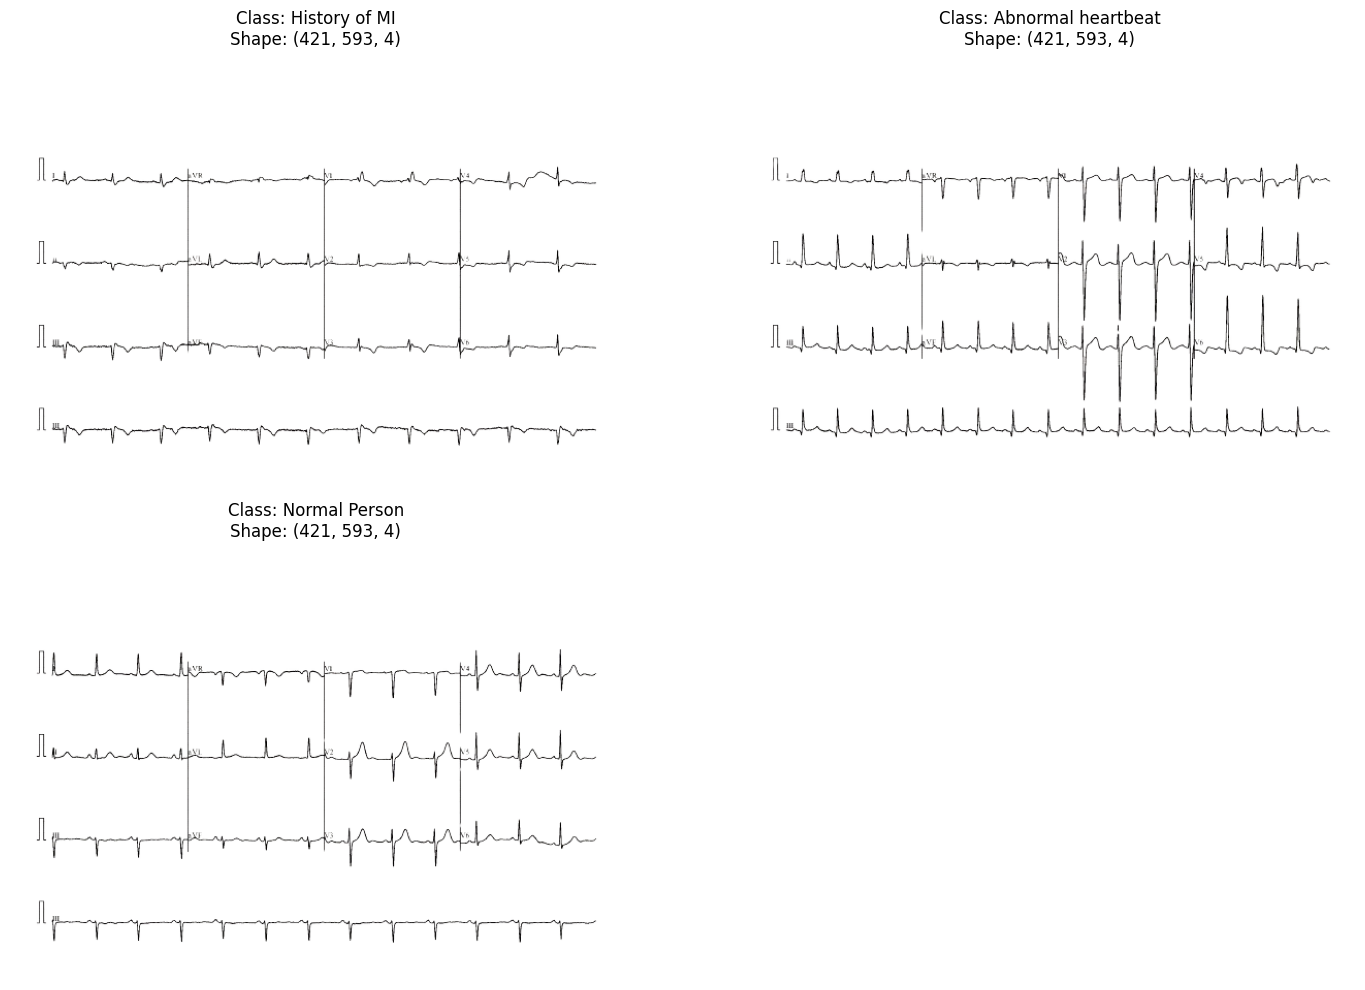

In [8]:
plt.figure(figsize=(15,10))
for i, label in enumerate(df['labels'].unique()):
    sample_path = df[df['labels']==label]['file_path'].iloc[0]
    img = mpimg.imread(sample_path)

    plt.subplot(2,2,i+1)
    plt.imshow(img, cmap='gray' if len(img.shape)==2 else None)
    plt.title(f"Class: {label}\nShape: {img.shape}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
X_train, X_test, y_train, y_test, label_encoder = create_dataset(dir_mendeley)
print("Shape of original traning data:", X_train.shape)
print("Label Encoder:", label_encoder)

Shape of original traning data: (565, 224, 224, 3)
Label Encoder: {'Abnormal heartbeat': 0, 'History of MI': 1, 'Normal Person': 2}


## VGG16

In [10]:
def create_transfer_learning_model(hp,num_classes):
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(hp.Int('dense_1_units', min_value=64, max_value=512, step=64), activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(layers.Dense(hp.Int('dense_2_units', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(layers.Dense(len(label_encoder), activation='softmax'))

    model.compile(
        optimizer=optimizers.Adam(hp.Choice('learning_rate', values=[1e-4, 1e-5, 1e-6])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# CUSTOM CNN

In [11]:
def create_custom_cnn_model(hp,num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(
        hp.Int('conv_1_filter', min_value=32, max_value=128, step=32),
        (3, 3),
        activation='relu',
        input_shape=(224, 224, 3)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(
        hp.Int('conv_2_filter', min_value=64, max_value=256, step=64),
        (3, 3),
        activation='relu'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(
        hp.Int('conv_3_filter', min_value=128, max_value=512, step=128),
        (3, 3),
        activation='relu'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(
        hp.Int('conv_4_filter', min_value=256, max_value=1024, step=256),
        (3, 3),
        activation='relu'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(
        hp.Int('dense_1_units', min_value=64, max_value=512, step=64),
        activation='relu'
    ))
    model.add(layers.Dropout(
        hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)
    ))
    model.add(layers.Dense(
        hp.Int('dense_2_units', min_value=32, max_value=256, step=32),
        activation='relu'
    ))
    model.add(layers.Dropout(
        hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)
    ))
    model.add(layers.Dense(len(label_encoder), activation='softmax'))
    model.compile(
        optimizer=optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-4, 1e-5, 1e-6])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# CNN-VGG16

In [12]:
def create_hybrid_cnn_vgg16_model(hp, num_classes):
    cnn_input = Input(shape=(224, 224, 3), name='cnn_input')
    x = layers.Conv2D(
        hp.Int('cnn_conv_1_filter', min_value=32, max_value=128, step=32),
        (3, 3),
        activation='relu',
        padding='same'
    )(cnn_input)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(
        hp.Int('cnn_conv_2_filter', min_value=64, max_value=256, step=64),
        (3, 3),
        activation='relu',
        padding='same'
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(
        hp.Int('cnn_conv_3_filter', min_value=128, max_value=512, step=128),
        (3, 3),
        activation='relu',
        padding='same'
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    if hp.Boolean('use_cnn_conv_4'):
        x = layers.Conv2D(
            hp.Int('cnn_conv_4_filter', min_value=256, max_value=1024, step=256),
            (3, 3),
            activation='relu',
            padding='same'
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
    cnn_output = layers.Flatten()(x)

    vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in vgg_base.layers:
        layer.trainable = False
    vgg_output = vgg_base(cnn_input)
    vgg_output = layers.Flatten()(vgg_output)


    combined = layers.concatenate([cnn_output, vgg_output])
    z = layers.Dense(
        hp.Int('combined_dense_1_units', min_value=64, max_value=512, step=64),
        activation='relu'
    )(combined)
    z = layers.Dropout(
        hp.Float('combined_dropout_1', min_value=0.2, max_value=0.5, step=0.1)
    )(z)
    z = layers.Dense(
        hp.Int('combined_dense_2_units', min_value=32, max_value=256, step=32),
        activation='relu'
    )(z)
    z = layers.Dropout(
        hp.Float('combined_dropout_2', min_value=0.2, max_value=0.5, step=0.1)
    )(z)
    output = layers.Dense(num_classes, activation='softmax')(z)

    model = Model(inputs=cnn_input, outputs=output)

    model.compile(
        optimizer=optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-4, 1e-5, 1e-6])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [13]:
def train_test_model(model_func, model_name, X_train, X_test, y_train, y_test):
    print(f"\n{'='*50}")
    print(f"Starting training and Evaluating for  {model_name}")
    print(f"{'='*50}")
    num_classes = len(np.unique(y_train))
    y_train_cat = to_categorical(y_train, num_classes=num_classes)
    y_test_cat = to_categorical(y_test, num_classes=num_classes)
    print("\nStarting Hyperparameter Tuning...")
    tuner = RandomSearch(
        lambda hp: model_func(hp, num_classes),
        objective='val_accuracy',
        max_trials=5,
        executions_per_trial=1,
        directory=f'hp_tuning_{model_name}',
        project_name=model_name
    )

    tuner.search(
        X_train, y_train_cat,
        epochs=20,
        validation_split=0.2,
        verbose=1,
    )
    best_hps = tuner.get_best_hyperparameters(1)[0]
    print("\nSelected Best Hyperparameters:")
    for param, value in best_hps.values.items():
        print(f"{param}: {value}")
    best_model = tuner.get_best_models(1)[0]
    print("\nModel Architecture:")
    best_model.summary()
    print("\nTraining Model using Best Hyperparameters...")
    history = best_model.fit(
        X_train, y_train_cat,
        epochs=40,
        validation_split=0.2,
        verbose=1,
    )
    print("\nEvaluating Model Performance...")
    y_pred = best_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test_cat, axis=1)
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    roc_auc = roc_auc_score(y_test_cat, y_pred, multi_class='ovr', average='weighted')
    print("\nEvaluation Metrics for the model:")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    plt.close()
    return best_model, history

## VGG16 ORIGINAL DATASET

Trial 5 Complete [00h 01m 34s]
val_accuracy: 0.8672566413879395

Best val_accuracy So Far: 0.9203540086746216
Total elapsed time: 00h 08m 03s

Selected Best Hyperparameters:
dense_1_units: 448
dropout_1: 0.2
dense_2_units: 128
dropout_2: 0.4
learning_rate: 0.0001

Model Architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 448)            │    11,239,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        57,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,012,419 (99.23 MB)

 Trainable params: 11,297,731 (43.10 MB)

 Non-trainable params: 14,714,688 (56.13 MB)


Training Model using Best Hyperparameters...
Epoch 1/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 484ms/step - accuracy: 0.8224 - loss: 0.4495 - val_accuracy: 0.8673 - val_loss: 0.3342
Epoch 2/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step - accuracy: 0.8762 - loss: 0.3649 - val_accuracy: 0.8673 - val_loss: 0.2924
Epoch 3/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - accuracy: 0.8418 - loss: 0.4128 - val_accuracy: 0.8938 - val_loss: 0.2885
Epoch 4/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - accuracy: 0.8737 - loss: 0.3528 - val_accuracy: 0.9115 - val_loss: 0.2554
Epoch 5/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 199ms/step - accuracy: 0.8066 - loss: 0.4520 - val_accuracy: 0.8761 - val_loss: 0.3244
Epoch 6/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step - accuracy: 0.8255 - loss: 0.4104 - val_accuracy: 0.9204 - val_loss: 0.2753
Epoch 7/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step - accuracy: 0.8654 - loss: 0.3365 - val_accuracy: 0.9204 - val_loss: 0.2692
Epoch 8/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step - acc

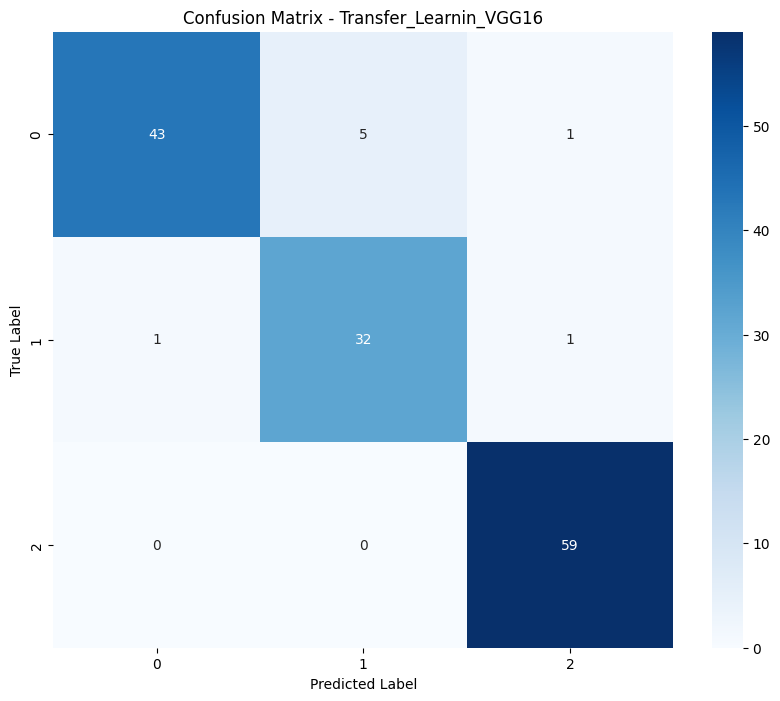

In [14]:
print("\nProcessing Transfer Learning Model...")
transfer_model, transfer_history = train_test_model(
    create_transfer_learning_model,
    "Transfer_Learnin_VGG16",
    X_train, X_test,
    y_train, y_test
)

# CNN ORIGINAL DATASET

Trial 5 Complete [00h 02m 06s]
val_accuracy: 0.20353981852531433

Best val_accuracy So Far: 0.4690265357494354
Total elapsed time: 00h 10m 17s

Selected Best Hyperparameters:
conv_1_filter: 32
conv_2_filter: 128
conv_3_filter: 384
conv_4_filter: 512
dense_1_units: 320
dropout_1: 0.30000000000000004
dense_2_units: 160
dropout_2: 0.2
learning_rate: 0.0001

Model Architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 128)  │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 384)    │       442,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 512)    │     1,769,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 320)            │    23,593,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 160)            │        51,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           483 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,899,971 (98.80 MB)

 Trainable params: 25,897,859 (98.79 MB)

 Non-trainable params: 2,112 (8.25 KB)


Training Model using Best Hyperparameters...
Epoch 1/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 659ms/step - accuracy: 0.8500 - loss: 0.4469 - val_accuracy: 0.4513 - val_loss: 5.7606
Epoch 2/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.8982 - loss: 0.2679 - val_accuracy: 0.4513 - val_loss: 5.2535
Epoch 3/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.8983 - loss: 0.2413 - val_accuracy: 0.4513 - val_loss: 5.3554
Epoch 4/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9156 - loss: 0.1805 - val_accuracy: 0.4513 - val_loss: 5.9943
Epoch 5/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.9228 - loss: 0.1404 - val_accuracy: 0.4513 - val_loss: 6.2279
Epoch 6/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.9637 - loss: 0.1095 - val_accuracy: 0.4513 - val_loss: 6.0188
Epoch 7/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.9691 - loss: 0.0909 - val_accuracy: 0.4513 - val_loss: 6.7882
Epoch 8/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - acc

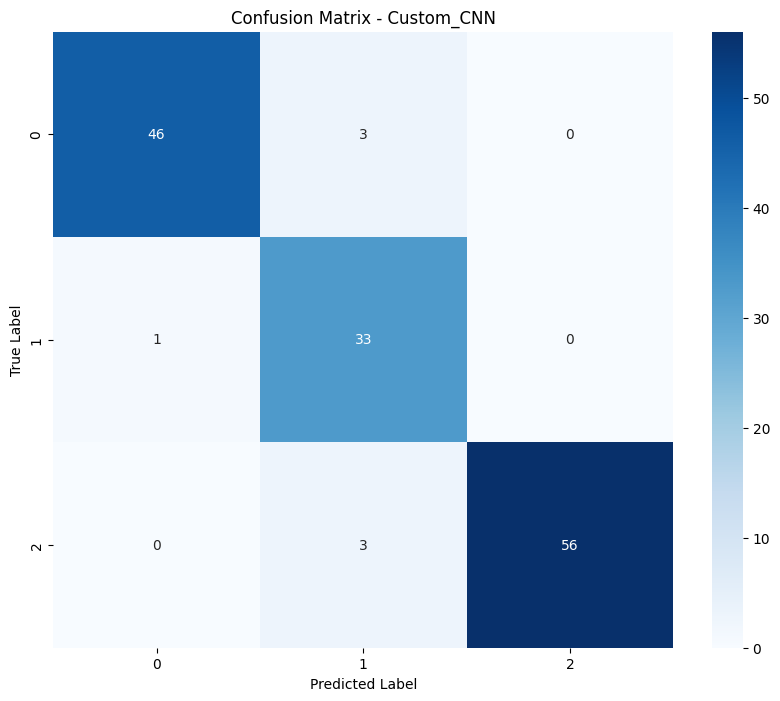

In [15]:
print("\nProcessing Custom CNN Model...")
cnn_model, cnn_history = train_test_model(
    create_custom_cnn_model,
    "Custom_CNN",
    X_train, X_test,
    y_train, y_test
)

# CNN-VGG16 ORIGINAL DATASET

Trial 5 Complete [00h 04m 38s]
val_accuracy: 0.4247787594795227

Best val_accuracy So Far: 0.5309734344482422
Total elapsed time: 00h 21m 19s

Selected Best Hyperparameters:
cnn_conv_1_filter: 32
cnn_conv_2_filter: 256
cnn_conv_3_filter: 128
use_cnn_conv_4: False
combined_dense_1_units: 448
combined_dropout_1: 0.2
combined_dense_2_units: 96
combined_dropout_2: 0.30000000000000004
learning_rate: 1e-06
cnn_conv_4_filter: 256

Model Architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cnn_input           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        896 │ cnn_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │     73,984 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │      1,024 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │    295,040 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ cnn_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 100352)    │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 25088)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 125440)    │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 448)       │ 56,197,568 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 448)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 96)        │     43,104 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 96)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 3)         │        291 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 71,327,235 (272.09 MB)

 Trainable params: 56,611,715 (215.96 MB)

 Non-trainable params: 14,715,520 (56.14 MB)


Training Model using Best Hyperparameters...
Epoch 1/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 818ms/step - accuracy: 0.8391 - loss: 0.4790 - val_accuracy: 0.4602 - val_loss: 1.3931
Epoch 2/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 322ms/step - accuracy: 0.8081 - loss: 0.5211 - val_accuracy: 0.5575 - val_loss: 1.4326
Epoch 3/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 365ms/step - accuracy: 0.8237 - loss: 0.5000 - val_accuracy: 0.5044 - val_loss: 1.4109
Epoch 4/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - accuracy: 0.8162 - loss: 0.4671 - val_accuracy: 0.5133 - val_loss: 1.4461
Epoch 5/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 328ms/step - accuracy: 0.8386 - loss: 0.4238 - val_accuracy: 0.5487 - val_loss: 1.4446
Epoch 6/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - accuracy: 0.8527 - loss: 0.4219 - val_accuracy: 0.5575 - val_loss: 1.4591
Epoch 7/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - accuracy: 0.8751 - loss: 0.3675 - val_accuracy: 0.5752 - val_loss: 1.4962
Epoch 8/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 363ms/step - acc

4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 721ms/step

Evaluation Metrics for the model:
Test Accuracy: 0.9366
F1 Score: 0.9362
ROC AUC Score: 0.9832


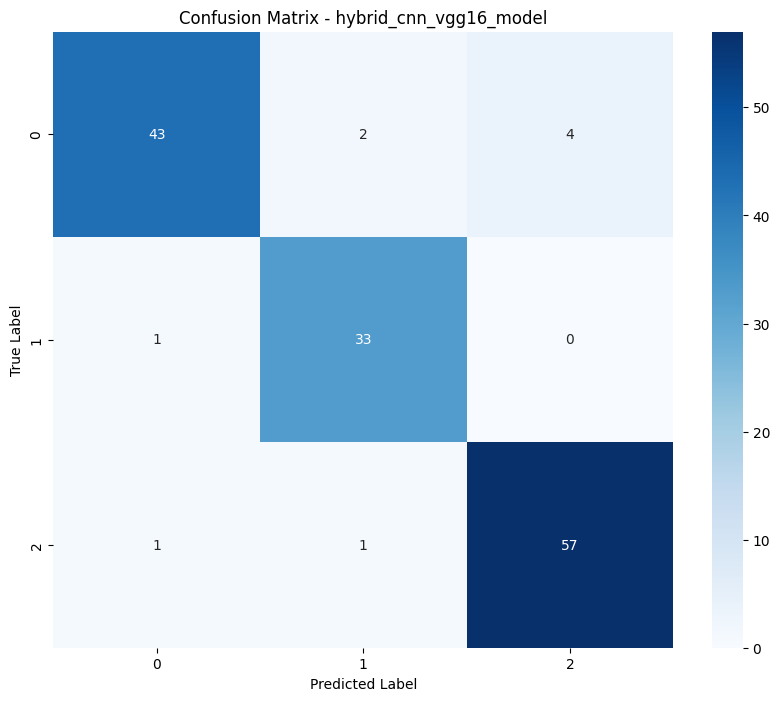

In [16]:
print("\nProcessing hybrid Model...")
hybrid_cnn_vgg16_model,hybrid_cnn_vgg16_model_history = train_test_model(
    create_hybrid_cnn_vgg16_model,
    "hybrid_cnn_vgg16_model",
    X_train, X_test,
    y_train, y_test
)

## Comparision Of Performance Metrics

In [20]:
metrics = {
    "Transfer_Learning_VGG16": {
        "accuracy": 0.9437,
        "f1": 0.9435,
        "roc_auc": 0.9838
    },
    "Custom_CNN": {
        "accuracy": 0.9507,
        "f1": 0.9518,
        "roc_auc": 0.9886
    },
    "Hybrid_CNN_VGG16": {
        "accuracy": 0.9366,
        "f1": 0.9362,
        "roc_auc": 0.9832
    }
}

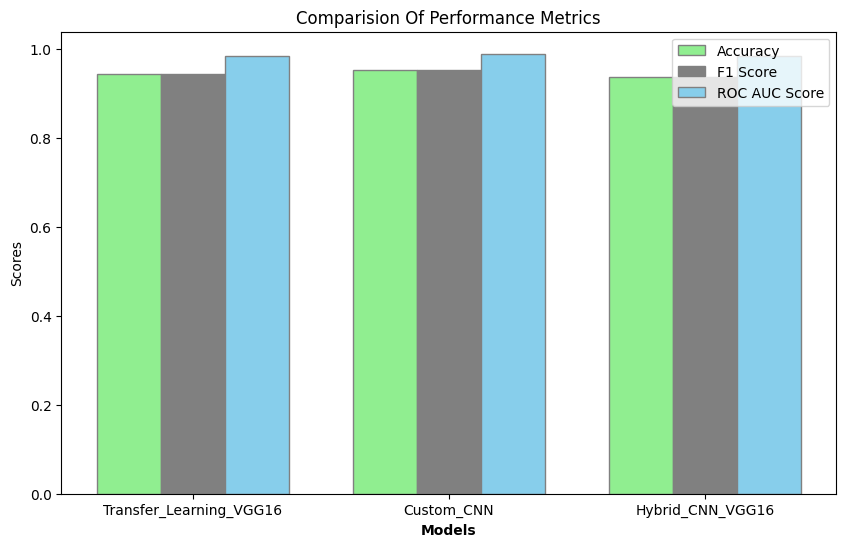

In [21]:
models = list(metrics.keys())
accuracies = [metrics[model]["accuracy"] for model in models]
f1_scores = [metrics[model]["f1"] for model in models]
roc_auc_scores = [metrics[model]["roc_auc"] for model in models]
bar_width = 0.25

r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
plt.figure(figsize=(10, 6))
plt.bar(r1, accuracies, color='Lightgreen', width=bar_width, edgecolor='grey', label='Accuracy')
plt.bar(r2, f1_scores, color='grey', width=bar_width, edgecolor='grey', label='F1 Score')
plt.bar(r3, roc_auc_scores, color='skyblue', width=bar_width, edgecolor='grey', label='ROC AUC Score')
plt.xlabel('Models', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(models))], models)
plt.ylabel('Scores')
plt.title('Comparision Of Performance Metrics')
plt.legend()
plt.show()

## Best Model Predictions

In [23]:
import keras
best_model_name = max(metrics, key=lambda k: metrics[k]['accuracy'])
best_model = None
if best_model_name == "Transfer_Learning_VGG16":
    best_model = transfer_model
elif best_model_name == "Custom_CNN":
    best_model = cnn_model
elif best_model_name == "Hybrid_CNN_VGG16":
    best_model = hybrid_cnn_vgg16_model
print(f"Selected Best Model: {best_model_name}")
best_model.save('best_heart_disease_model.h5')
loaded_model = keras.models.load_model('best_heart_disease_model.h5')
def predict_with_best_model(image_path, model, label_encoder):
    "class prediction with confidence score"
    image = prepare_image(image_path)
    if image is not None:
        image = image.reshape(1, *image.shape)
        prediction = model.predict(image)
        predicted_class_index = np.argmax(prediction)
        confidence_score = prediction[0][predicted_class_index]
        class_labels = list(label_encoder.keys())
        predicted_class_label = class_labels[predicted_class_index]
        return predicted_class_label, confidence_score
    else:
        print(f"Image input error unable to process {image_path}")
        return None, None

Selected Best Model: Custom_CNN


In [24]:
image_path = input("Enter the path to your image: ")
print(f"\nUsing Best Model: {best_model_name}")
print(f"Image Path: {image_path}")
predicted_class, confidence = predict_with_best_model(image_path, loaded_model, label_encoder)
if predicted_class is not None:
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence Score: {confidence:.2%}")

Enter the path to your image: /content/drive/MyDrive/Colab Notebooks/ECGM/Abnormal heartbeat/HB_(102).png

Using Best Model: Custom_CNN
Image Path: /content/drive/MyDrive/Colab Notebooks/ECGM/Abnormal heartbeat/HB_(102).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: Abnormal heartbeat
Confidence Score: 99.95%
